In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import json
import re
from fbprophet import Prophet
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
import torch.nn.functional as F
from tqdm.autonotebook import trange, tqdm
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    from tensorboardX import SummaryWriter

C:\Users\silas\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [2]:
key = 'G6IWTDY03TVAVHTK'
symbol = 'AMD'
interval = '1min'

In [3]:
# api_call = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={symbol}&interval={interval}&outputsize=full&apikey={key}'
api_call = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={key}'

In [4]:
req = requests.get(api_call)

In [5]:
amd_ts = json.loads(req.text)

In [6]:
meta = amd_ts['Meta Data']

In [7]:
data = amd_ts['Time Series (Daily)']

In [8]:
meta

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'AMD',
 '3. Last Refreshed': '2020-01-27',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [9]:
amd_df = pd.DataFrame(data).T

In [10]:
amd_df.columns

Index(['1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [11]:
col_name = {'1. open': 'Open', '2. high': 'High', '3. low':'Low', '4. close': 'Close', '5. volume': 'Volume', 'index': 'Time'}
amd_df = amd_df.reset_index()
amd_df = amd_df.rename(columns=col_name)

In [12]:
amd_df.tail()

,Time,Open,High,Low,Close,Volume
5027,2000-02-01,36.5000,36.7500,35.0000,36.5600,2555600
5028,2000-01-31,35.2500,36.2500,34.4400,36.0000,2144400
5029,2000-01-28,37.1900,37.7500,34.3800,35.2500,3433600
5030,2000-01-27,38.0000,39.0000,36.8800,36.9400,3083900
5031,2000-01-26,37.6300,38.2500,36.5600,37.0000,3798900


In [13]:
amd_open = amd_df[['Time', 'Open']]
amd_open = amd_open.rename(columns={'Time':'ds', 'Open': 'y'})
m = Prophet()
m.fit(amd_open)
future = m.make_future_dataframe(periods=420)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\silas\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [14]:
forecast = m.predict(future)

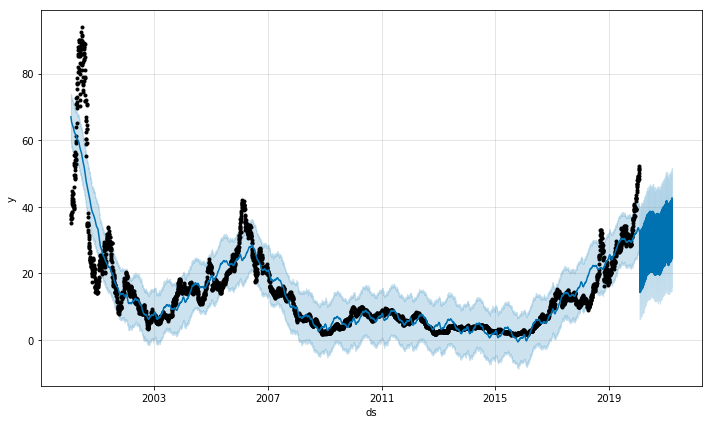

In [15]:
fig1 = m.plot(forecast)

In [16]:
amd_df.to_csv('amd_daily_data.csv')

In [31]:
class regressor(torch.nn.Module):
    def __init__(self):
        super(regressor, self).__init__()
        self.input = torch.nn.Linear(10, 32)
        self.layer_1 = torch.nn.Linear(32, 16)
        self.layer_2 = torch.nn.Linear(16, 4)
        self.output = torch.nn.Linear(4, 1)
        
        self.ReLU = torch.nn.ReLU
        
        
    def forward(self, x):
        x = self.input(x)
        x = self.ReLU(x)
        x = self.layer_1(x)
        x = self.ReLU(x)
        x = self.layer_2(x)
        x = self.ReLU(x)
        x = self.output(x)
        return x

In [32]:
reg_net = regressor()
optimizer = torch.optim.Adam(reg_net.parameters(), lr=.0001)
criterion = torch.nn.MSELoss()

In [36]:
# Create autoregressive dataset
dataset = pd.concat([amd_open[['y']].rename(columns={'y': f'x_{i}'}).shift(i) for i in range(1, 11)], axis=1)
dataset.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52.2803,48.4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51.3400,52.2803,48.4500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51.6300,51.3400,52.2803,48.4500,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
x = dataset.to_numpy()[10:]
y = amd_open['y'].to_numpy()[10:]

In [45]:
x.shape

(5022, 10)

In [48]:
x

array([['48.6600', '48.6400', '48.2300', ..., '51.3400', '52.2803',
        '48.4500'],
       ['49.2600', '48.6600', '48.6400', ..., '51.6300', '51.3400',
        '52.2803'],
       ['48.9400', '49.2600', '48.6600', ..., '50.9600', '51.6300',
        '51.3400'],
       ...,
       ['35.2500', '36.5000', '36.3100', ..., '41.3800', '42.0600',
        '42.7500'],
       ['37.1900', '35.2500', '36.5000', ..., '41.0000', '41.3800',
        '42.0600'],
       ['38.0000', '37.1900', '35.2500', ..., '38.5600', '41.0000',
        '41.3800']], dtype=object)

In [46]:
y. shape

(5022,)

In [47]:
num_epochs = 10
for epoch in range(num_epochs):
    for xi, yi in zip(x, y):
        xt = torch.tensor(xi)
        yt = torch.tensor(yi)
        optimizer.zero_grad()
        estimate = reg_net(xi)
        loss = criterion(estimate, yi)
        loss.backward()
        optimizer.step()

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.